# ML HidroPrev com a API Keras

In [2]:
# Bibliotecas
import eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import keras
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
dados_manaus = eda.data_processing('Cotas extraidas', '1903-01-01', '2024-12-31', ['dados_diarios_estacao_14990000.csv'])
dados_manaus

,14990000
Data,
1903-01-01,1914.0
1903-01-02,1921.0
1903-01-03,1924.0
1903-01-04,1926.0
1903-01-05,1929.0
...,...
2024-12-27,1751.0
2024-12-28,1769.0
2024-12-29,1785.0


### Machine Learning

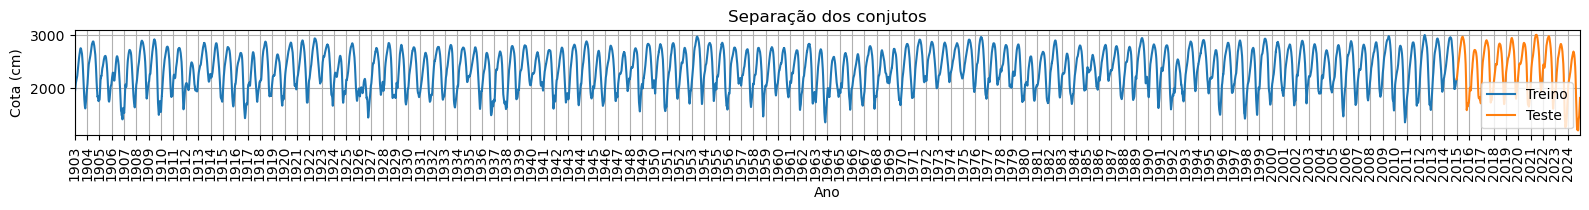

In [4]:
# Separação do conjunto
treino = dados_manaus[:'2014-12-31']
teste = dados_manaus['2015-01-01':]

plt.figure(figsize=(16, 2))
plt.plot(treino['14990000'])
plt.plot(teste['14990000'])
plt.legend(['Treino', 'Teste'])
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.xticks(rotation=90)
plt.xlim(dados_manaus.index[0], dados_manaus.index[-1])
plt.tight_layout()
plt.title('Separação dos conjutos')
plt.show()

##### MLP

Aplicando o mesmo método usado no HidroPrev_ASAC23

In [5]:
# Criação de batches
window_length = 365
shifts = np.arange(1,window_length+1)
# Create a dictionary of time-shifted data
x_shifts = {'lag_{}'.format(ii): treino['14990000'].shift(ii) for ii in shifts}
# Convert the shifts into a dataframe
x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)

In [6]:
mlp = keras.models.Sequential([
    keras.layers.Input(shape=x_shifts.shape[1:]),
    keras.layers.Dense(11, activation='relu'),
    keras.layers.Dense(11, activation='relu'),
    keras.layers.Dense(1)
])

mlp.compile(loss='mse', metrics=[keras.metrics.R2Score()], optimizer='adam')

mlp.fit(x_shifts.iloc[window_length:], treino['14990000'][window_length:], epochs=1000, verbose=0)

I0000 00:00:1753374126.323947  109069 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1027 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1753374127.592662  111665 service.cc:152] XLA service 0x7aab04003d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753374127.592684  111665 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-07-24 12:22:07.624051: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753374127.708943  111665 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753374128.238777  111665 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
test_predictions = []
first_eval_batch = treino['14990000'][-window_length:].values
current_batch = first_eval_batch.reshape((1, window_length))

for i in range(len(teste)):
    current_pred = mlp.predict(current_batch, verbose=0)[0][0]

    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:],[[current_pred]],axis=1)

R²: 0.5471, MSE: 87739.2961, RMSE: 296.2082, MAE: 198.0809


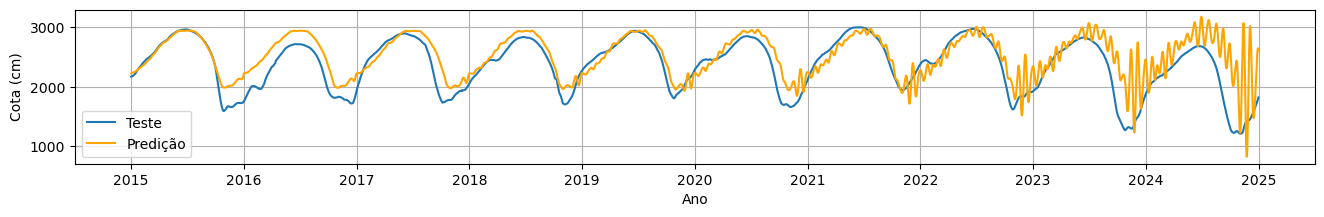

In [8]:
y_pred = pd.DataFrame(test_predictions)
y_pred.index = teste['14990000'].index

r2 = r2_score(teste['14990000'], y_pred)
mse = mean_squared_error(teste['14990000'], y_pred)
rmse = root_mean_squared_error(teste['14990000'], y_pred)
mae = mean_absolute_error(teste['14990000'], y_pred)

print(f'R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

plt.figure(figsize=(16, 2))
plt.plot(teste['14990000'], label='Teste')
plt.plot(y_pred, label='Predição', color='orange')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.legend()
plt.show()

##### LSTM

In [5]:
def create_multi_step_dataset(series, janela, n_steps):
    X, y = [], []
    for i in range(len(series) - janela - n_steps + 1):
        X.append(series[i:i+janela])
        y.append(series[i+janela:i+janela+n_steps])
    return np.array(X), np.array(y)

In [19]:
janela = 15
steps = 15

X, y = create_multi_step_dataset(dados_manaus['14990000'].values, janela, steps)

x_train = X[:treino.shape[0]-janela]
y_train = y[:treino.shape[0]-janela]

x_test = X[treino.shape[0]-janela:]
y_test = y[treino.shape[0]-janela:]

x_scale = MinMaxScaler()
x_train = x_scale.fit_transform(x_train)
x_test = x_scale.transform(x_test)

y_scale = MinMaxScaler()
y_train = y_scale.fit_transform(y_train)
y_test = y_scale.transform(y_test)

In [20]:
lstm = keras.models.Sequential([
    keras.layers.Input(shape=(janela, 1)),
    keras.layers.LSTM(150),
    keras.layers.Dense(steps)
])

lstm.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

lstm.fit(x_train, y_train, epochs=50)

Epoch 1/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0168 - mean_absolute_error: 0.0687
Epoch 2/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 6.1569e-04 - mean_absolute_error: 0.0179
Epoch 3/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4.3669e-04 - mean_absolute_error: 0.0143
Epoch 4/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 3.9764e-04 - mean_absolute_error: 0.0137
Epoch 5/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 3.3255e-04 - mean_absolute_error: 0.0124
Epoch 6/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 3.0098e-04 - mean_absolute_error: 0.0115
Epoch 7/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2.9265e-04 - mean_absolute_error: 0.0114
Epoch 8/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2.7230e-04 - mean_absolute_error: 0.0110
Epoch 9/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 2.6280e-04 - mean_absolute_error: 0.0107
Epoch 10/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 2.4461e-04 - m

In [21]:
pred = lstm.predict(x_test)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [22]:
pred_inv = y_scale.inverse_transform(pred)
y_test_inv = y_scale.inverse_transform(y_test)

R²: 0.9999


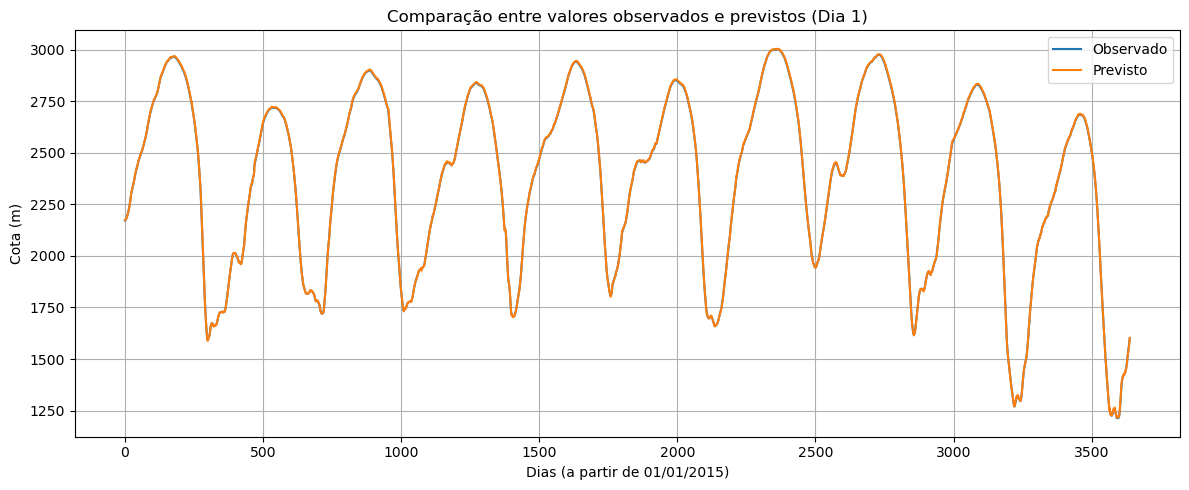

R²: 0.9985


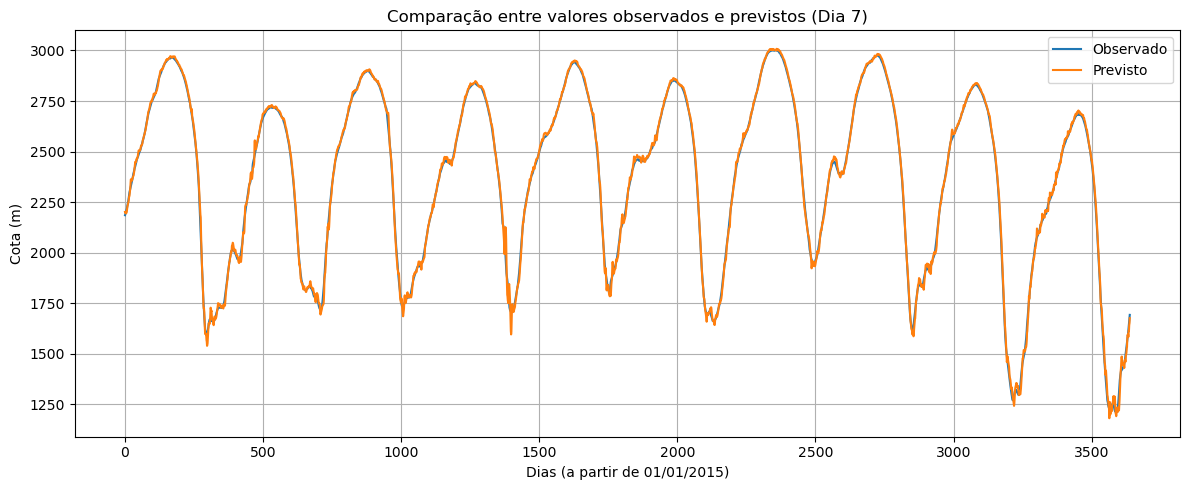

R²: 0.9902


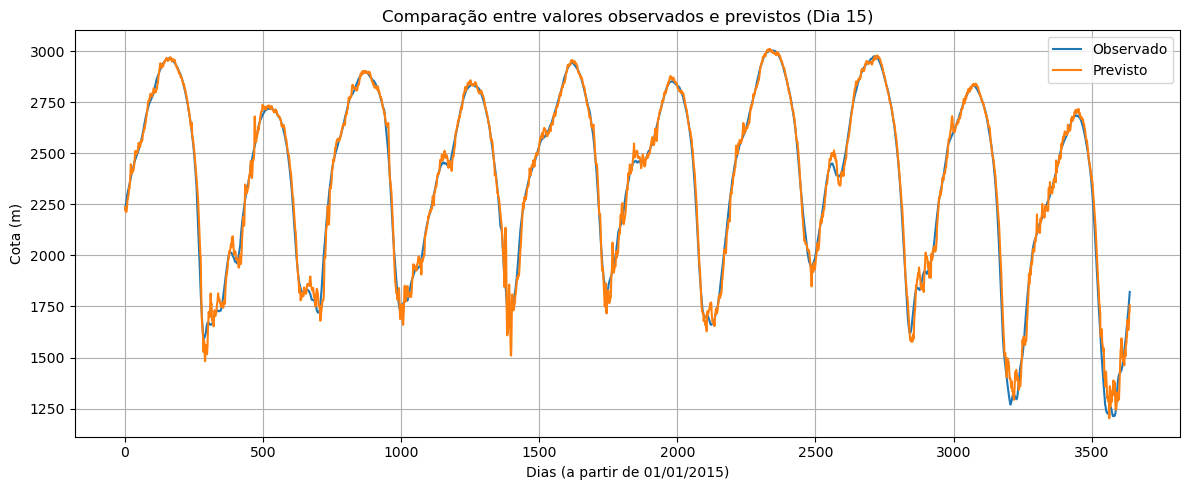

In [23]:
horizonte = [1, 7, 15]

for i in horizonte:
    print(f"R²: {r2_score(y_test_inv[:,i-1], pred_inv[:,i-1]):.4f}")
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv[:,i-1], label='Observado')
    plt.plot(pred_inv[:,i-1], label='Previsto')
    plt.xlabel('Dias (a partir de 01/01/2015)')
    plt.ylabel('Cota (m)')
    plt.title(f'Comparação entre valores observados e previstos (Dia {i})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Testando com dados de 2025, até 31 de maio

In [24]:
dados_manaus2 = eda.data_processing('Cotas extraidas', '2025-01-01', '2025-05-31', ['dados_diarios_estacao_14990000.csv'])
dados_manaus2

,14990000
Data,
2025-01-01,1838.0
2025-01-02,1856.0
2025-01-03,1876.0
2025-01-04,1896.0
2025-01-05,1915.0
...,...
2025-05-27,2847.0
2025-05-28,2849.0
2025-05-29,2852.0


In [25]:
x_test2, y_test2 =  create_multi_step_dataset(dados_manaus2['14990000'].values, janela, steps)

x_test2 = x_scale.transform(x_test2)

In [26]:
pred2 = lstm.predict(x_test2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [27]:
pred2_inv = y_scale.inverse_transform(pred2)

R²: 0.9998


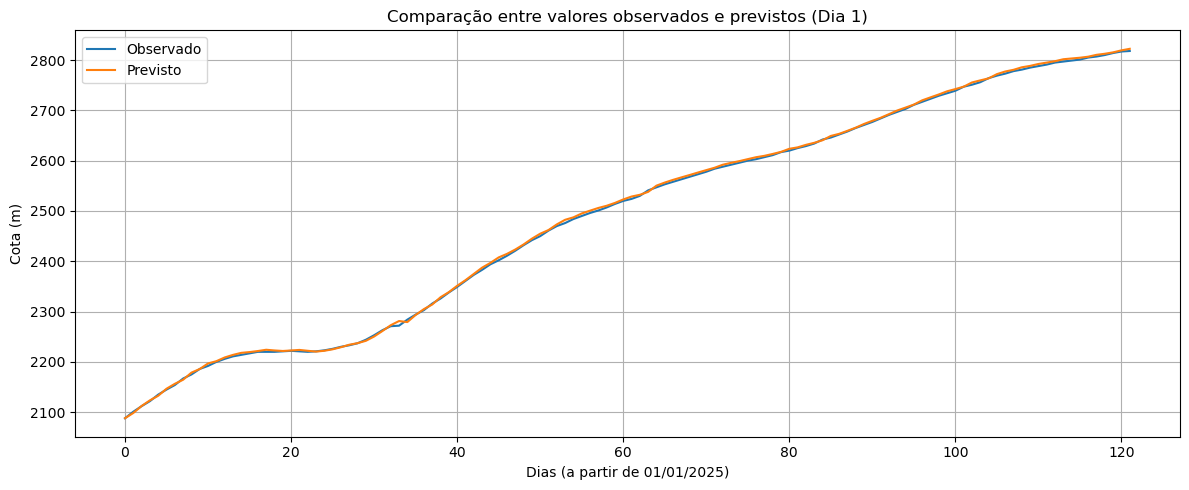

R²: 0.9969


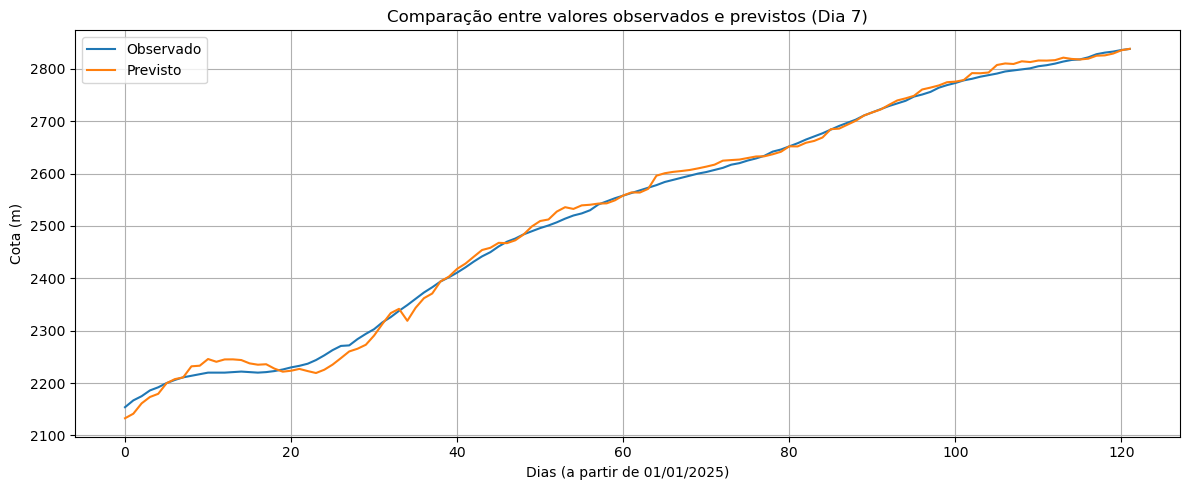

R²: 0.9739


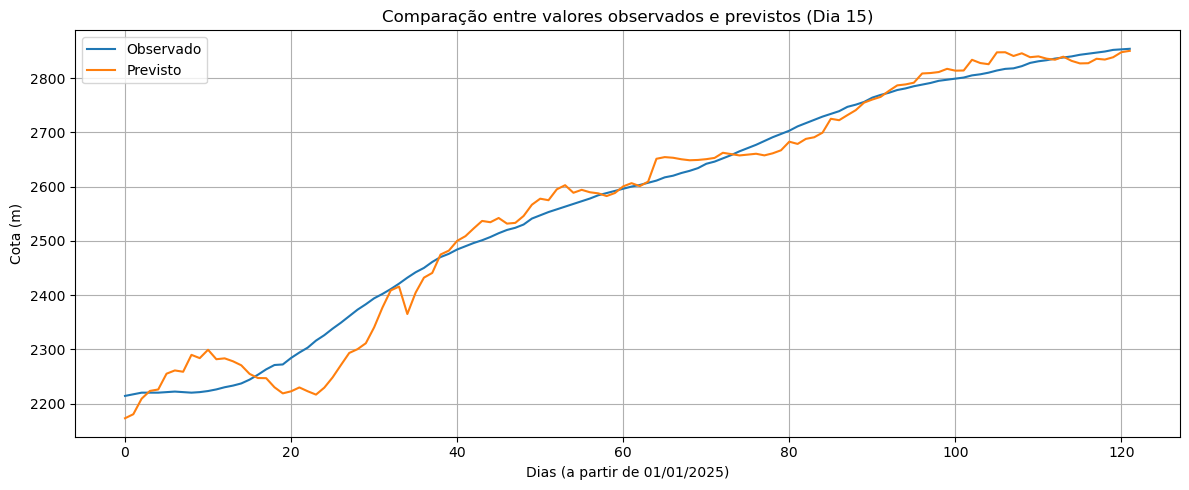

In [29]:
for i in horizonte:
    print(f"R²: {r2_score(y_test2[:,i-1], pred2_inv[:,i-1]):.4f}")
    plt.figure(figsize=(12, 5))
    plt.plot(y_test2[:,i-1], label='Observado')
    plt.plot(pred2_inv[:,i-1], label='Previsto')
    plt.xlabel('Dias (a partir de 01/01/2025)')
    plt.ylabel('Cota (m)')
    plt.title(f'Comparação entre valores observados e previstos (Dia {i})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()